<a href="https://colab.research.google.com/github/shahpriyanka26/shahpriyanka26/blob/main/PS_ZS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business License Status Prediction

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from datetime import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
# Importing the dataset
train_data = pd.read_csv("/content/train_file.csv")
train_data.head()

In [ ]:
train_data.shape

In [ ]:
# Importing the test dataset
test_data = pd.read_csv("/content/test_file.csv")
test_data.head()

In [ ]:
test_data.shape

(57239, 31)

In [ ]:
#creating consistent format for zip codes
temp = train_data['ZIP CODE'].tolist()
train_data['ZIP CODE'] = [str(sub).replace('.0', '') for sub in temp]

In [ ]:
temp = test_data['ZIP CODE'].tolist()
test_data['ZIP CODE'] = [str(sub).replace('.0', '') for sub in temp]

In [ ]:
#creating result dataframe
my_submission = pd.DataFrame({'ID': test_data.ID})
my_submission.head()

,ID
0,1516615-20120216
1,69813-20110616
2,1519227-20041116
3,1922025-20100816
4,1675683-20070816


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


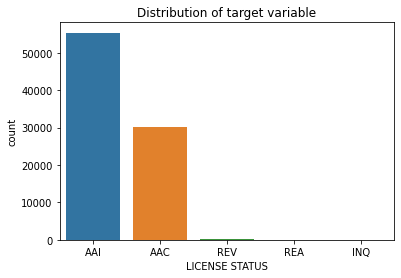

In [ ]:
#Distribution of dependent label
plt.title('Distribution of target variable')
sns.countplot(train_data['LICENSE STATUS'])
plt.show()

In [ ]:
#dependent label count
train_data['LICENSE STATUS'].value_counts()

AAI    55400
AAC    30200
REV      290
REA        3
INQ        2
Name: LICENSE STATUS, dtype: int64

In [ ]:
#summary of categorical variables in train data

train_data.describe(include='object').T

,count,unique,top,freq
ID,85895,85895,35342-20020816,1
LEGAL NAME,85895,38744,WASTE MANAGEMENT OF ILLINOIS INC.,689
DOING BUSINESS AS NAME,85894,41686,WASTE MANAGEMENT METRO,610
ADDRESS,85895,42146,1500 N HOOKER ST,537
CITY,85895,1223,CHICAGO,36744
STATE,85895,54,IL,80546
ZIP CODE,85895,1721,60618,1738
WARD PRECINCT,36195,2383,42-,1448
LICENSE DESCRIPTION,85895,106,Limited Business License,50078
APPLICATION TYPE,85895,5,RENEW,61085


In [ ]:
#Summary of numerical variables in train data
train_data.describe().T


,count,mean,std,min,25%,50%,75%,max
LICENSE ID,85895.0,1.751303e+06,335877.991460,30793.000000,1.469024e+06,1.778754e+06,2.067578e+06,2.456551e+06
ACCOUNT NUMBER,85895.0,1.966954e+05,126819.343760,10.000000,5.461500e+04,2.483130e+05,3.002435e+05,3.974440e+05
SITE NUMBER,85895.0,2.556028e+00,8.655706,1.000000,1.000000e+00,1.000000e+00,2.000000e+00,4.170000e+02
WARD,36194.0,2.852893e+01,13.921710,1.000000,1.700000e+01,3.000000e+01,4.200000e+01,5.000000e+01
PRECINCT,29194.0,5.463297e+01,163.174955,1.000000,1.200000e+01,2.600000e+01,4.100000e+01,9.990000e+02
POLICE DISTRICT,31883.0,1.352981e+01,7.275874,1.000000,8.000000e+00,1.400000e+01,1.900000e+01,1.810000e+02
LICENSE CODE,85895.0,1.111737e+03,250.020872,1002.000000,1.010000e+03,1.010000e+03,1.011000e+03,8.340000e+03
LICENSE NUMBER,85894.0,1.228151e+06,743148.710120,129.000000,8.710900e+04,1.442202e+06,1.816581e+06,2.391410e+06
SSA,9449.0,2.915208e+01,17.419898,1.000000,1.700000e+01,2.800000e+01,4.000000e+01,6.900000e+01
LATITUDE,38649.0,4.188095e+01,0.079617,41.644694,4.183431e+01,4.189268e+01,4.193862e+01,4.202266e+01


In [ ]:
def missingValueInDataFrame(df_act):
    '''Calculate percentage of missing data in each column'''
    list_colName=[]
    list_colUnique=[]
    list_lenColUnique=[]
    for col in df_act.columns:
        list_colName.append(col)
        list_colUnique.append(df_act[col].unique())
        list_lenColUnique.append(len(df_act[col].unique()))

    df_colInfo=pd.DataFrame(list(zip(list_colName,list_colUnique,list_lenColUnique,list(df_act.isnull().sum()/len(df_act)*100))), columns=["columnName","columnUnique","uniqueLen","missingValPercent"]).sort_values(by="missingValPercent", ascending=False)
    
    
    return df_colInfo

def repeatedValueInDataFrame(df_act):
    '''Calculate columns with highly repetitive values'''
    list_colName=[]
    list_valKey=[]
    list_valPercent=[]
    list_max=[]

    list_frstKey=[]
    list_firstVal=[]

    for col in df_act.columns:
        dct=dict(df_act[col].value_counts())
        if len(dct)<10:
            list_colName.append(col)
            list_valKey.append(list(dct.keys()))
            lst=[i/len(df_act)*100 for i in list(dct.values())]
            list_valPercent.append(lst)
            list_max.append(max(lst))
            list_frstKey.append(list(dct.keys())[0])
            list_firstVal.append(lst[0])


    df_repeatedval0=pd.DataFrame(list(zip(list_colName,list_valKey,list_valPercent,list_max)), columns=["columnName","list_valKey","list_valPercent","list_max"]).sort_values(by="list_max", ascending=False)

    df_repeatedval=pd.DataFrame(list(zip(list_colName,list_frstKey,list_firstVal)), columns=["columnName","ReapeatedValue","PercentageRepeatedValue"]).sort_values(by="PercentageRepeatedValue", ascending=False)
    df_repeatedval.head(10)
    
    return df_repeatedval



In [ ]:
#missing value summary
missingValueInDataFrame(train_data)

,columnName,columnUnique,uniqueLen,missingValPercent
27,SSA,"[25.0, 60.0, nan, 14.0, 28.0, 45.0, 24.0, 10.0...",54,88.999360
18,APPLICATION CREATED DATE,"[nan, 2009-06-29T00:00:00, 2004-02-10T00:00:00...",2900,75.277956
11,PRECINCT,"[28.0, 23.0, nan, 6.0, 999.0, 37.0, 17.0, 21.0...",77,66.011991
26,LICENSE STATUS CHANGE DATE,"[nan, 2006-06-15T00:00:00, 2004-05-04T00:00:00...",3153,64.497351
13,POLICE DISTRICT,"[10.0, 17.0, nan, 12.0, 25.0, 18.0, 8.0, 16.0,...",29,62.881425
10,WARD,"[22.0, 33.0, nan, 25.0, 35.0, 2.0, 18.0, 17.0,...",51,57.862507
12,WARD PRECINCT,"[22-28, 33-23, nan, 25-6, 35-999, 2-37, 22-17,...",2384,57.861342
30,LOCATION,"[{'latitude': '41.843612879431845', 'longitude...",21389,55.004366
29,LONGITUDE,"[-87.71461847200001, -87.699626044, nan, -87.6...",21389,55.004366
28,LATITUDE,"[41.843612879, 41.961132441, nan, 41.856222491...",21387,55.004366


In [ ]:
#highly repeated values
repeatedValueInDataFrame(train_data)

In [ ]:
train_data['CONDITIONAL APPROVAL'].value_counts()

In [ ]:
""" Usage: pandas_entropy(df['column1']) """
import scipy
def pandas_entropy(column):
    p_data = column.value_counts() 
    return scipy.stats.entropy(p_data) 

In [ ]:
sh_df = train_data.apply(pandas_entropy,axis=0)
sh_df.sort_values()

In [ ]:
#drop ID columns and columns with lots of repeated catgorical values

In [ ]:
# Dropping columns which will be of no use for our model

col_list = ['APPLICATION CREATED DATE', 'SSA', 'LICENSE ID', 'ID', 'ADDRESS','LICENSE NUMBER','CONDITIONAL APPROVAL','LICENSE STATUS CHANGE DATE']

In [ ]:
# Dropping columns which will be of no use for our model
train_data = train_data.drop(col_list, axis=1)
test_data = test_data.drop(col_list, axis=1)

In [ ]:
train_data.columns

In [ ]:
#from scipy.stats import kendalltau, pearsonr, spearmanr

In [ ]:
# Function to extraxt year and month from datetime data
def convert_datetime(date_cols):
    for i in date_cols:
        train_data[i] = pd.to_datetime(train_data[i])
        test_data[i] = pd.to_datetime(test_data[i])

In [ ]:
date_list = ['APPLICATION REQUIREMENTS COMPLETE', 'PAYMENT DATE', 'LICENSE TERM EXPIRATION DATE', 'LICENSE TERM START DATE',
             'DATE ISSUED', 'LICENSE APPROVED FOR ISSUANCE']
convert_datetime(date_list)

In [ ]:
train_data[date_list].isna().sum()

In [ ]:
train_data["Validity Days"] = (train_data['LICENSE TERM EXPIRATION DATE'] - train_data['LICENSE TERM START DATE']).dt.days
test_data["Validity Days"] = (test_data['LICENSE TERM EXPIRATION DATE'] - test_data['LICENSE TERM START DATE']).dt.days

In [ ]:
train_data["Validity Days"].isna().sum()

In [ ]:
# Function to impute missing values by rounded value of mean
def round_mean(imp_mean_list):
    for i in imp_mean_list:
        train_data[i] = train_data[i].fillna(round(train_data[i].mean()))
        test_data[i] = test_data[i].fillna(round(train_data[i].mean()))

In [ ]:
imp_mean_list = ['Validity Days','LATITUDE', 'LONGITUDE']
round_mean(imp_mean_list)

In [ ]:
train_data["Validity Days"].isna().sum()

In [ ]:
# Function to obtain year and month from datetime data
def get_yearmonth(colname_y,colname_m, dfcolname,df):
    df[colname_y] = df[dfcolname].dt.year
    df[colname_m] = df[dfcolname].dt.month
    df = df.drop(dfcolname, axis=1)
    return df

In [ ]:
for col in date_list:
    print(col)
    colname_y = col + " Year"
    colname_m = col + " Month"
    train_data = get_yearmonth(colname_y,colname_m, col,train_data)
    test_data = get_yearmonth(colname_y,colname_m, col,test_data)
    
    
    

In [ ]:
train_data.columns

In [ ]:
test_data.head(5)

In [ ]:
year_list = ['LICENSE TERM EXPIRATION DATE Year', 'LICENSE TERM START DATE Year', 'PAYMENT DATE Year', 'LICENSE APPROVED FOR ISSUANCE Year',
                 'APPLICATION REQUIREMENTS COMPLETE Year']
for year_col in year_list:
    train_data[year_col] = train_data[year_col].fillna(train_data['DATE ISSUED Year'])
    test_data[year_col] = test_data[year_col].fillna(test_data['DATE ISSUED Year'])

In [ ]:

list1 = ['LEGAL NAME', 'DOING BUSINESS AS NAME']
train_data[list1].isna().sum()

In [ ]:
train_data[list1]

In [ ]:
# imputation of related columns
train_data['DOING BUSINESS AS NAME'] = train_data['DOING BUSINESS AS NAME'].fillna(train_data['LEGAL NAME'])
test_data['DOING BUSINESS AS NAME'] = test_data['DOING BUSINESS AS NAME'].fillna(test_data['LEGAL NAME'])


test_data[list1].isna().sum()

In [ ]:
# feature engineering
train_data['Company'] = 'PVT'
test_data['Company'] = 'PVT'

In [ ]:
train_data['Company'] = np.where(train_data['DOING BUSINESS AS NAME'].str.contains('INC'), 'INC', train_data['Company'])
train_data['Company'] = np.where(train_data['DOING BUSINESS AS NAME'].str.contains('INCORPORATED'), 'INC', train_data['Company'])

train_data['Company'] = np.where(train_data['LEGAL NAME'].str.contains('INC'), 'INC', train_data['Company'])
train_data['Company'] = np.where(train_data['LEGAL NAME'].str.contains('INCORPORATED'), 'INC', train_data['Company'])

In [ ]:
test_data['Company'] = np.where(test_data['DOING BUSINESS AS NAME'].str.contains('INC'), 'INC', test_data['Company'])
test_data['Company'] = np.where(test_data['DOING BUSINESS AS NAME'].str.contains('INCORPORATED'), 'INC', test_data['Company'])

test_data['Company'] = np.where(test_data['LEGAL NAME'].str.contains('INC'), 'INC', test_data['Company'])
test_data['Company'] = np.where(test_data['LEGAL NAME'].str.contains('INCORPORATED'), 'INC', test_data['Company'])

In [ ]:
train_data['Company'] = np.where(train_data['DOING BUSINESS AS NAME'].str.contains('LLC'), 'LLC', train_data['Company'])
test_data['Company'] = np.where(test_data['DOING BUSINESS AS NAME'].str.contains('LLC'), 'LLC', test_data['Company'])

train_data['Company'] = np.where(train_data['LEGAL NAME'].str.contains('LLC'), 'LLC', train_data['Company'])
test_data['Company'] = np.where(test_data['LEGAL NAME'].str.contains('LLC'), 'LLC', test_data['Company'])

In [ ]:
train_data['Company'] = np.where(train_data['DOING BUSINESS AS NAME'].str.contains('CO'), 'CORP', train_data['Company'])
train_data['Company'] = np.where(train_data['DOING BUSINESS AS NAME'].str.contains('CORP'), 'CORP', train_data['Company'])
train_data['Company'] = np.where(train_data['DOING BUSINESS AS NAME'].str.contains('CORPORATION'), 'CORP', train_data['Company'])

test_data['Company'] = np.where(test_data['DOING BUSINESS AS NAME'].str.contains('CO'), 'CORP', test_data['Company'])
test_data['Company'] = np.where(test_data['DOING BUSINESS AS NAME'].str.contains('CORP'), 'CORP', test_data['Company'])
test_data['Company'] = np.where(test_data['DOING BUSINESS AS NAME'].str.contains('CORPORATION'), 'CORP', test_data['Company'])


train_data['Company'] = np.where(train_data['LEGAL NAME'].str.contains('CO'), 'CORP', train_data['Company'])
train_data['Company'] = np.where(train_data['LEGAL NAME'].str.contains('CORP'), 'CORP', train_data['Company'])
train_data['Company'] = np.where(train_data['LEGAL NAME'].str.contains('CORPORATION'), 'CORP', train_data['Company'])

test_data['Company'] = np.where(test_data['LEGAL NAME'].str.contains('CO'), 'CORP', test_data['Company'])
test_data['Company'] = np.where(test_data['LEGAL NAME'].str.contains('CORP'), 'CORP', test_data['Company'])
test_data['Company'] = np.where(test_data['LEGAL NAME'].str.contains('CORPORATION'), 'CORP', test_data['Company'])

In [ ]:
train_data['Company'] = np.where(train_data['DOING BUSINESS AS NAME'].str.contains('LTD'), 'LTD', train_data['Company'])
train_data['Company'] = np.where(train_data['DOING BUSINESS AS NAME'].str.contains('LIMITED'), 'LTD', train_data['Company'])

test_data['Company'] = np.where(test_data['DOING BUSINESS AS NAME'].str.contains('LTD'), 'LTD', test_data['Company'])
test_data['Company'] = np.where(test_data['DOING BUSINESS AS NAME'].str.contains('LIMITED'), 'LTD', test_data['Company'])

train_data['Company'] = np.where(train_data['LEGAL NAME'].str.contains('LTD'), 'LTD', train_data['Company'])
train_data['Company'] = np.where(train_data['LEGAL NAME'].str.contains('LIMITED'), 'LTD', train_data['Company'])

test_data['Company'] = np.where(test_data['LEGAL NAME'].str.contains('LTD'), 'LTD', test_data['Company'])
test_data['Company'] = np.where(test_data['LEGAL NAME'].str.contains('LIMITED'), 'LTD', test_data['Company'])

In [ ]:
train_data['Company'].isna().sum()

In [ ]:
test_data['Company'].isna().sum()

In [ ]:
train_data['Company'].value_counts()

In [ ]:
col_list = ['DOING BUSINESS AS NAME', 'LEGAL NAME']
# Dropping columns 
train_data = train_data.drop(col_list, axis=1)
test_data = test_data.drop(col_list, axis=1)

In [ ]:
len(train_data['LICENSE DESCRIPTION'].unique())

In [ ]:
train_data['LICENSE DESCRIPTION'].unique()

In [ ]:
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Motor Vehicle Repair : Engine Only (Class II)', 'Motor Vehicle Repair')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Motor Vehicle Repair: Engine/Body(Class III)', 'Motor Vehicle Repair')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Motor Vehicle Repair; Specialty(Class I)', 'Motor Vehicle Repair')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Day Care Center Under 2 Years', 'Day Care Center')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Day Care Center 2 - 6 Years', 'Day Care Center')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Day Care Center Under 2 and 2 - 6 Years', 'Day Care Center')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Peddler, non-food', 'Peddler')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Peddler, non-food, special', 'Peddler')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Peddler, food (fruits and vegtables only)', 'Peddler')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Peddler,food - (fruits and vegetables only) - special', 'Peddler')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Tire Facilty Class I (100 - 1,000 Tires)', 'Tire Facilty')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Tire Facility Class II (1,001 - 5,000 Tires)', 'Tire Facilty')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Tire Facility Class III (5,001 - More Tires)', 'Tire Facilty')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Repossessor Class A', 'Repossessor')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Repossessor Class B', 'Repossessor')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Repossessor Class B Employee', 'Repossessor')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Expediter - Class B', 'Expediter')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Expediter - Class A', 'Expediter')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Expediter - Class B Employee', 'Expediter')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Itinerant Merchant, Class II', 'Itinerant Merchant')
train_data['LICENSE DESCRIPTION'] = train_data['LICENSE DESCRIPTION'].replace('Itinerant Merchant, Class I', 'Itinerant Merchant')

In [ ]:
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Motor Vehicle Repair : Engine Only (Class II)', 'Motor Vehicle Repair')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Motor Vehicle Repair: Engine/Body(Class III)', 'Motor Vehicle Repair')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Motor Vehicle Repair; Specialty(Class I)', 'Motor Vehicle Repair')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Day Care Center Under 2 Years', 'Day Care Center')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Day Care Center 2 - 6 Years', 'Day Care Center')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Day Care Center Under 2 and 2 - 6 Years', 'Day Care Center')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Peddler, non-food', 'Peddler')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Peddler, non-food, special', 'Peddler')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Peddler, food (fruits and vegtables only)', 'Peddler')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Peddler,food - (fruits and vegetables only) - special', 'Peddler')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Tire Facilty Class I (100 - 1,000 Tires)', 'Tire Facilty')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Tire Facility Class II (1,001 - 5,000 Tires)', 'Tire Facilty')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Tire Facility Class III (5,001 - More Tires)', 'Tire Facilty')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Repossessor Class A', 'Repossessor')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Repossessor Class B', 'Repossessor')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Repossessor Class B Employee', 'Repossessor')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Expediter - Class B', 'Expediter')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Expediter - Class A', 'Expediter')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Expediter - Class B Employee', 'Expediter')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Itinerant Merchant, Class II', 'Itinerant Merchant')
test_data['LICENSE DESCRIPTION'] = test_data['LICENSE DESCRIPTION'].replace('Itinerant Merchant, Class I', 'Itinerant Merchant')

In [ ]:
cols = ["LICENSE APPROVED FOR ISSUANCE Month", "PAYMENT DATE Month",'LICENSE TERM START DATE Month','APPLICATION REQUIREMENTS COMPLETE Month','ZIP CODE','LICENSE TERM EXPIRATION DATE Month']
train_data[cols]=train_data[cols].fillna(train_data.mode().iloc[0])
test_data[cols]=test_data[cols].fillna(train_data.mode().iloc[0])

In [ ]:
train_data['ZIP CODE'].isna().sum()

In [ ]:
col_list = ['PRECINCT', 'POLICE DISTRICT', 'WARD', 'WARD PRECINCT','LOCATION' ]
# Dropping columns 
train_data = train_data.drop(col_list, axis=1)
test_data = test_data.drop(col_list, axis=1)

In [ ]:
missingValueInDataFrame(train_data)

In [ ]:
train_data["LICENSE STATUS"] = train_data["LICENSE STATUS"].replace('AAI', 0)
train_data["LICENSE STATUS"] = train_data["LICENSE STATUS"].replace('AAC', 1)
train_data["LICENSE STATUS"] = train_data["LICENSE STATUS"].replace('REV', 2)
train_data["LICENSE STATUS"] = train_data["LICENSE STATUS"].replace('REA', 3)
train_data["LICENSE STATUS"] = train_data["LICENSE STATUS"].replace('INQ', 4)

In [ ]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [ ]:
train=train_data
test=test_data

In [ ]:
train['LICENSE STATUS']

In [ ]:
cols = ['CITY', 'STATE','ZIP CODE','LICENSE DESCRIPTION','APPLICATION TYPE','Company']
for col in cols:
    label_encoder = LabelEncoderExt()
    label_encoder.fit(train[col])
    train[col] = label_encoder.transform(train[col])
    test[col] = label_encoder.transform(test[col])
    

In [ ]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

train = train.sample(frac=1)

# Amount of fraud classes in proportion.
fraud_df = train[train['LICENSE STATUS'] == 4]
pending_df = train[train['LICENSE STATUS'] == 3]
accepted_df = train[train['LICENSE STATUS'] == 2]

non_fraud_df = train[train['LICENSE STATUS'] == 1][:290]
non_accepted_df = train[train['LICENSE STATUS'] == 0][:300]

normal_distributed_df = pd.concat([fraud_df, pending_df, accepted_df, non_fraud_df, non_accepted_df, fraud_df,
                                  fraud_df, fraud_df, fraud_df, pending_df, pending_df, fraud_df, pending_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

In [ ]:
plt.title('Distribution of target variable')
sns.countplot(new_df['LICENSE STATUS'])
plt.show()

In [ ]:
# Our Subsample
sub_sample_corr = new_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(sub_sample_corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':20}, cmap='Greens')
plt.title('Subsample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [ ]:
new_df.columns

In [ ]:
list_col = ['APPLICATION REQUIREMENTS COMPLETE Year','PAYMENT DATE Year', 'PAYMENT DATE Month', 'LICENSE TERM EXPIRATION DATE Year', 'LICENSE TERM EXPIRATION DATE Month', 'LICENSE TERM START DATE Year', 'LICENSE TERM START DATE Month', 'DATE ISSUED Year', 'DATE ISSUED Month', 'LICENSE APPROVED FOR ISSUANCE Year', 'LICENSE APPROVED FOR ISSUANCE Month']
#train_data = train_data.drop(list_col, axis=1)
#test_data = test_data.drop(list_col, axis=1)
new_df = new_df.drop(list_col, axis=1)

In [ ]:
# Our Subsample
sub_sample_corr = new_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(sub_sample_corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':20}, cmap='Greens')
plt.title('Subsample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
variables =new_df.columns[1:].tolist()
values= new_df.loc[:, variables].values
target_values=new_df.loc[:,['LICENSE STATUS']].values
X_pca = PCA().fit_transform(values)
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_pca[:, 1], X_pca[:, 4], c=target_values)

In [ ]:
# Import for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


# Prepare a dataframe for VIF
X_VIF = add_constant(new_df)


# Calculate VIF scores
vif_scores = pd.DataFrame([variance_inflation_factor(X_VIF.values, i) 
               for i in range(X_VIF.shape[1])], 
              index=X_VIF.columns)
# Prepare a final dataframe of VIF scores
vif_scores.reset_index(inplace = True)
vif_scores.columns = ['Feature', 'VIFscore']
vif_scores = vif_scores.loc[vif_scores['Feature'] != 'const', :]
vif_scores = vif_scores.sort_values(by = ['VIFscore'], ascending = False)
vif_scores

In [ ]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('LICENSE STATUS', axis=1)
y = new_df['LICENSE STATUS']

In [ ]:
# Splitting the data into training set and testset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 1)

In [ ]:
# A function to create confusion matrix function to find out sensitivity and specificity
from sklearn.metrics import confusion_matrix
def draw_cm(actual, predicted):
    cm = confusion_matrix( actual, predicted, [1,0]).T
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["Yes","No"] , yticklabels = ["Yes","No"] )
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.show()

In [ ]:
# eXtreme Gradient Boosting

# Import library of xgboost model
from xgboost import XGBClassifier, plot_importance

# Create a XGB Classifier
gbm = XGBClassifier(learning_rate=0.02, n_estimators=1000, objective='multi:softmax', silent=True, nthread=1, num_class=5)

# A parameter grid for XGBoost for Hyperparameter Optimization
parameters = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 6]
        }

# Run the grid search
grid_obj = GridSearchCV(gbm, parameters)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the rf to the best combination of parameters
gbm = grid_obj.best_estimator_

# Train the model using the training sets
gbm.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.6, gamma=0.1, learning_rate=0.02,
              n_estimators=1000, nthread=1, num_class=5,
              objective='multi:softprob', silent=True, subsample=1.0)

In [ ]:
# Prediction on test data
y_pred = gbm.predict(X_test)

In [ ]:
# Calculating the accuracy, precision and the recall
acc_xgb = round( metrics.accuracy_score(y_test, y_pred) * 100 , 2 )
print( 'Total Accuracy : ', acc_xgb )

Total Accuracy :  80.09


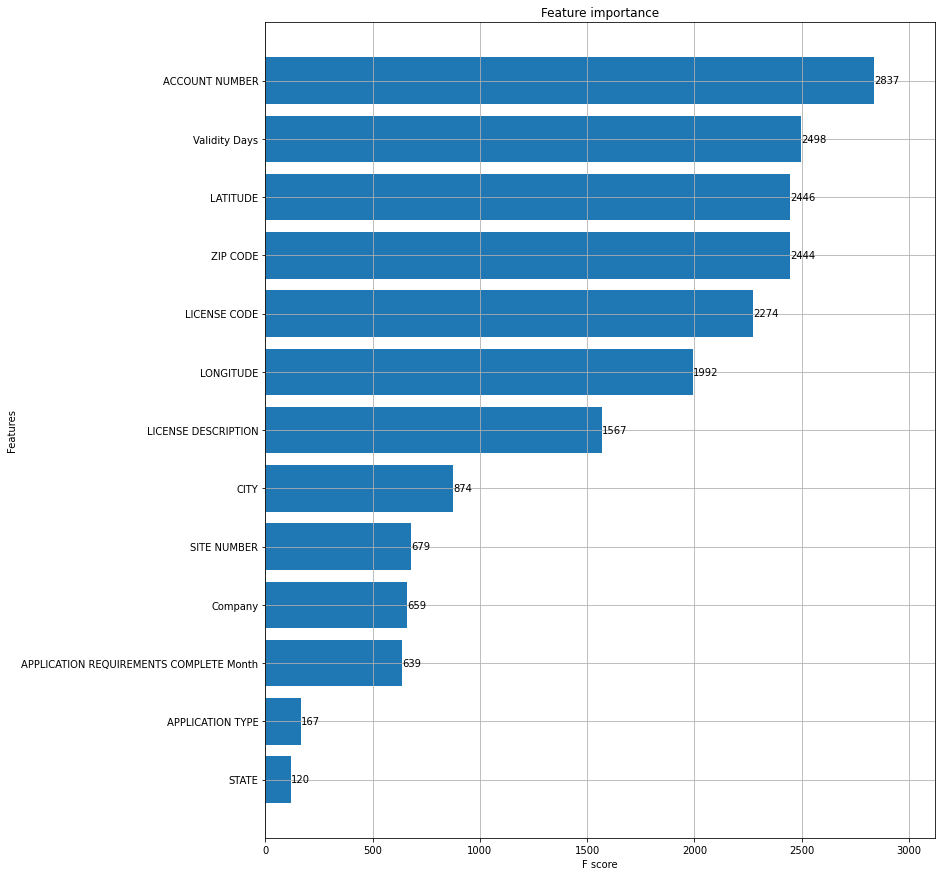

In [ ]:
# Feature Engineering
fig, ax = plt.subplots(figsize=(12,15))
plot_importance(gbm, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
gbm.get_booster().get_score(importance_type="gain")

{'ACCOUNT NUMBER': 0.8985785388768067,
 'APPLICATION REQUIREMENTS COMPLETE Month': 0.7004194837019407,
 'APPLICATION TYPE': 0.9287402138622759,
 'CITY': 1.4450481372814659,
 'Company': 1.078191620867983,
 'LATITUDE': 2.15869548315405,
 'LICENSE CODE': 2.527264731718426,
 'LICENSE DESCRIPTION': 2.4747642356123842,
 'LONGITUDE': 3.6893364733845466,
 'SITE NUMBER': 1.4048599965640642,
 'STATE': 0.2439476532500001,
 'Validity Days': 1.3931570922576864,
 'ZIP CODE': 1.5991371399112053}

In [ ]:
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

NameError: ignored

In [ ]:
# Predicting on the test dataset
my_pred = gbm.predict(test_data)

In [ ]:
my_submission['LICENSE STATUS'] = my_pred

In [ ]:
my_submission.shape

In [ ]:
my_submission['LICENSE STATUS'] = my_submission['LICENSE STATUS'].replace(0, 'AAI')
my_submission['LICENSE STATUS'] = my_submission['LICENSE STATUS'].replace(1, 'AAC')
my_submission['LICENSE STATUS'] = my_submission['LICENSE STATUS'].replace(2, 'REV')
my_submission['LICENSE STATUS'] = my_submission['LICENSE STATUS'].replace(3, 'REA')
my_submission['LICENSE STATUS'] = my_submission['LICENSE STATUS'].replace(4, 'INQ')

In [ ]:
my_submission.to_csv('PS_submission1.csv',index=False)

# Random Forest Classifier

In [ ]:
# Random Forest Classifier

# Import library of RandomForestClassifier model
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Hyperparameter Optimization
parameters = {'n_estimators': [4, 6, 9, 10, 15], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

# Run the grid search
grid_obj = GridSearchCV(rf, parameters)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the rf to the best combination of parameters
rf = grid_obj.best_estimator_

# Train the model using the training sets 
rf.fit(X_train,y_train)

In [ ]:
# Finding the variable with more importance
feature_imp = pd.Series(rf.feature_importances_,index= X_train.columns).sort_values(ascending=False)
# Creating a bar plot
feature_imp=feature_imp[0:10,]
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
# Prediction on test data
y_pred = rf.predict(X_test)

In [ ]:
# Confusion metrix
draw_cm(y_test, y_pred)

In [ ]:
# Calculating the accuracy, precision and the recall
acc_rf = round( metrics.accuracy_score(y_test, y_pred) * 100 , 2 )
print( 'Total Accuracy : ', acc_rf )

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score

In [ ]:
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

In [ ]:
models = [('rf',rf),('xgb',gbm)
stacking = StackingClassifier(estimators=models)